In [1]:
import matplotlib
##matplotlib.use("Agg")
import matplotlib.pyplot as plt

import sys
import time
import scipy.io as io
import os
from os import listdir
import glob
import time

import csv
import cv2
import numpy as np
from opt_flow import draw_flow

from scipy.ndimage.filters import generic_filter
from scipy import ndimage as ndi

import math
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, binary_opening, binary_dilation, disk,remove_small_objects,label,binary_erosion
from skimage.color import label2rgb
from skimage import data, color, io, img_as_float

from skimage.draw import rectangle_perimeter
from skimage.draw import rectangle
from scipy.signal import find_peaks
from skimage.filters import gaussian

import math
import pandas as pd


from memory_profiler import profile
import multiprocessing
from joblib import Parallel, delayed

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.') and not f.startswith('contractivity'):
            yield f


def getLargestCC(segmentation):
    labels = label(segmentation)
    ###assert( labels.max() != 0 ) # assume at least 1 CC
    if labels.max()==0:
        return segmentation
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def SimilarityComparison(img10, img20):
    img1 = gaussian(img10, sigma=1)
    img2 = gaussian(img20, sigma=1)
   
    reg_hei,reg_wid = img10.shape
    
    N = reg_hei*reg_wid

    norm_term1 = np.sum(np.multiply(img1,img2))*N
    norm_term2 = np.sum(img1)*np.sum(img2)

    denorm_term1 = N*np.sum(np.multiply(img1,img1))-np.sum(img1)*np.sum(img1)
    denorm_term2 = N*np.sum(np.multiply(img2,img2))-np.sum(img2)*np.sum(img2)

    SC = (norm_term1-norm_term2)*(norm_term1-norm_term2)/(denorm_term1*denorm_term2)
    
    return SC

def cellSegmentation(frame_ref):
    I_filt = generic_filter(frame_ref, np.std, size=11)
    thresh = np.percentile(I_filt[:], 85)
    valid_region = np.zeros(I_filt.shape)
    valid_region[10:-10,10:-10] = 1
    I_filt = np.multiply(I_filt,valid_region)
    result0 =  I_filt>thresh
    result1 = binary_opening(result0,disk(11))
    result1 = remove_small_objects(result1,1500)
    mask_label = label(result1)
    return mask_label


def ExtractTracePatch(mask_region,magStack,frameStack,frame_ref):
    mask_region_stack = np.repeat(mask_region[:, :, np.newaxis], magStack.shape[2], axis=2)
    mask_region_size = np.sum(mask_region)
    ##print(mask_region_size)
    ##plt.imshow(mask_region_stack[:,:,200])
    magStack_mask = np.multiply(magStack, mask_region_stack.astype(int))
    flow_trace = np.sum(magStack_mask,axis=0)
    flow_trace = np.sum(flow_trace, axis=0)/mask_region_size

    hei,wid,imgNum = frameStack.shape 

    
    active_px = np.argwhere(mask_region>0)
    x,y,w,h = cv2.boundingRect(active_px)
    
    SC_values_patch = np.zeros(imgNum)
    for kk in range(imgNum):
        SC_values_patch[kk] = SimilarityComparison(frame_ref[x:x+w-1,y:y+h-1], frameStack[x:x+w-1,y:y+h-1,kk])

    SC_values_patch[-1]= 0
    return flow_trace, SC_values_patch


def iPSC_pipeline(RootPath,OutputPath,subfolder,ds=1):
   
    subfolder = RootPath + "\\" + subfolder
    (dirName,videoFileName) = os.path.split(subfolder)
    print(subfolder)
    if not os.path.exists(OutputPath):
            os.mkdir(OutputPath)
            print("Directory " , OutputPath ,  " Created ")
    else:    
            print("Directory " , OutputPath ,  " already exists")


    csvOutputName =OutputPath+"\\"+videoFileName+"_endpoints.csv"
    fout = open(csvOutputName, 'w', newline='')
    writer = csv.writer(fout)
    writer.writerow( ('subFolder','Optical_A_index', 'Optical_B_index', 'OpticalFlow_A_value','OpticalFlow_B_value','Correlation_diff_A_index','Correlation_diff_B_index','Correlation_diff_C_index','Correlation_diff_D_index','Correlation_diff_A_value','Correlation_diff_B_value','OpticalFlow_baseline') )
    fout.flush()  
    
    imageNameRoot =  subfolder  + "\\tiff\\*.tif"
    
    imageNames = sorted(glob.glob(imageNameRoot))
    
    ###imageNames=imageNames[0:500]
    
    imageNum = len(imageNames)
    
    
    print(imageNum)
    print(imageNames[0])
    img0 = cv2.imread(imageNames[0])
    frame1 = img0[::ds,::ds,:]
    frame_ref = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)

    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    hei, wid = prvs.shape

    magStack = np.zeros([hei, wid, int(imageNum)-1],dtype =  np.float32)
    angStack = np.zeros([hei, wid, int(imageNum)-1],dtype =  np.float32)
    frameStack = np.zeros([hei, wid, int(imageNum)-1],dtype =  np.float32)

    SC_values_ref = np.zeros(int(imageNum)-1)
    

    videoOut = OutputPath+"\\"+videoFileName + '_opticalFlow.avi'
    print(videoOut)

    fps = 50
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    VideoOutput = cv2.VideoWriter(videoOut, fourcc, fps, (2*wid,hei))


    ###for ii in range(1,imageNum-1):
    for ii in range(1,imageNum-1):

        img2 = cv2.imread(imageNames[ii])
        frame20 = img2[::ds,::ds,:]
        frame2 = cv2.cvtColor(frame20,cv2.COLOR_BGR2GRAY)

        next = frame2

        SC_values_ref[ii-1] = SimilarityComparison(frame_ref, frame2)

        prvs_s = prvs
        next_s = next
      
        flow = cv2.calcOpticalFlowFarneback(prvs_s,next_s, None, .5, 3, 15, 3, 5, 1.2, 0)
        ###flow = cv2.calcOpticalFlowFarneback(prvs_s,next_s, None, pyr_scale = 0.5, levels = 5, winsize = 11, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        #hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        hsv[...,2] = mag*380
        #print(np.max(mag))
        bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        vis = draw_flow(next, flow*80)

        magStack[:,:,ii-1] = mag
        frameStack[:,:,ii-1] = frame2

        if ii%100==0:
            print(ii)
        prvs = next

        frame_final = np.concatenate((bgr,vis),axis=1)
        VideoOutput.write(frame_final)

    VideoOutput.release()    
    cv2.destroyAllWindows()

    SC_diff = (np.gradient(SC_values_ref[:-10]))
    

    mask_label = cellSegmentation(frame_ref)
    cellNum = np.max(mask_label[:])
    for cellTag in range(1,cellNum+1):
        ###for jj in range(0,1):# just one object
        mask_region = (mask_label==cellTag)  ## mask_region = (mask_label>0)  for  1011 dataset; mask_region = (mask_label==0) 1018dataset, 1020dataset,1022dataset,1028?
        active_px = np.argwhere(mask_region>0)
        x,y,w,h = cv2.boundingRect(active_px)
        rr, cc = rectangle_perimeter(start=(x,y), end=(x+w,y+h), shape=mask_label.shape)

        flow_trace,SC_values_patch = ExtractTracePatch(mask_region,magStack,frameStack,frame_ref)

        rawDataFileName = OutputPath+"\\"+videoFileName + "_cell_" + str(cellTag)+"_feature_traces.npz"
        np.savez(rawDataFileName,optical_flow_trace = flow_trace,similary_measure = SC_values_ref)



        fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1)
        plt.rcParams['figure.figsize'] = [28, 32]
                ###plt.subplot(211)

        alpha = 0.8
        frame_disp = frame1
        img_hsv = color.rgb2hsv(frame_disp)
        color_mask = np.zeros(frame_disp.shape)
        color_mask[...,0] = mask_region.astype(float)*255
        color_mask[...,1] = mask_region.astype(float)*255
        #color_mask[...,2] = magMask.astype(np.float)*255
        color_mask_hsv = color.rgb2hsv(color_mask)

        img_hsv[..., 0] = color_mask_hsv[..., 0]
        img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
        img_masked = color.hsv2rgb(img_hsv)
        img_masked[rr,cc,:]=255

        ax1.imshow(img_masked)
        ax2.plot(flow_trace[1:-10],linewidth=2)
        ax3.plot(1-SC_values_ref[:-10],linewidth=2)
        ax4.plot(abs(SC_diff[1:-10]),linewidth=2)


        displayFigureName2 = OutputPath+"\\"+videoFileName+"_cell_" + str(cellTag)+"_result.png"
        print(displayFigureName2)
        fig.savefig(displayFigureName2)
        fig.clf()
        plt.close(fig)
        
        ###
        return magStack

    
if __name__ == "__main__":

    ds = 2

    RootPath =   r'Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1'
    OutputPath = r'Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1_output1'
    ###RootPath =   'Z:\\pangj05\\RDRU_MYBPC3_2021\\20211020DataSetAnalysis\\Plate1'

    ###OutputPath = 'Z:\\pangj05\\RDRU_MYBPC3_2021\\20211020DataSetAnalysis\\Plate1_output_ar1'

    subfolders = list(listdir_nohidden(RootPath))
 
    cpu_num = 1
 
    subFolders = sorted(list(listdir_nohidden(RootPath)))
    subFolders = subFolders[0:1]
    magStack = iPSC_pipeline(RootPath,OutputPath,subFolders[0],ds)
    ##for mm in range(1,5):
    ###    subfolder = subFolders[mm]
    ###    iPSC_pipeline(RootPath,OutputPath,subfolder,ds)
    ###Parallel(n_jobs=cpu_num,prefer='threads')(delayed(iPSC_pipeline)(RootPath,OutputPath,subfolder,ds) for subfolder in subFolders)   





Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1\220221_ICells_Mattek_s01
Directory  Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1_output1  already exists
1457
Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1\220221_ICells_Mattek_s01\tiff\220221_ICells_Mattek_s01_frame_0001.tif.tif
Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1_output1\220221_ICells_Mattek_s01_opticalFlow.avi
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


<ipython-input-1-544cfce9f637>:71: RuntimeWarning: invalid value encountered in double_scalars
  SC = (norm_term1-norm_term2)*(norm_term1-norm_term2)/(denorm_term1*denorm_term2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1_output1\220221_ICells_Mattek_s01_cell_1_result.png


In [2]:
subfolder= subFolders[0]
subfolder = RootPath + "\\" + subfolder
(dirName,videoFileName) = os.path.split(subfolder)
print(subfolder)
if not os.path.exists(OutputPath):
        os.mkdir(OutputPath)
        print("Directory " , OutputPath ,  " Created ")
else:    
        print("Directory " , OutputPath ,  " already exists")


csvOutputName =OutputPath+"\\"+videoFileName+"_endpoints.csv"
fout = open(csvOutputName, 'w', newline='')
writer = csv.writer(fout)
writer.writerow( ('subFolder','Optical_A_index', 'Optical_B_index', 'OpticalFlow_A_value','OpticalFlow_B_value','Correlation_diff_A_index','Correlation_diff_B_index','Correlation_diff_C_index','Correlation_diff_D_index','Correlation_diff_A_value','Correlation_diff_B_value','OpticalFlow_baseline') )
fout.flush()  

imageNameRoot =  subfolder  + "\\tiff\\*.tif"
imageNames = sorted(glob.glob(imageNameRoot))

Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1\220221_ICells_Mattek_s01
Directory  Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1_output1  already exists


In [3]:
print(imageNames[0])

Z:\pangj05\RDRU_MYBPC3_2022\0221_iCells_Patterned_Dishes_DataSetAnalysis\220221_ICells_Mattek_Dish_1\220221_ICells_Mattek_s01\tiff\220221_ICells_Mattek_s01_frame_0001.tif.tif


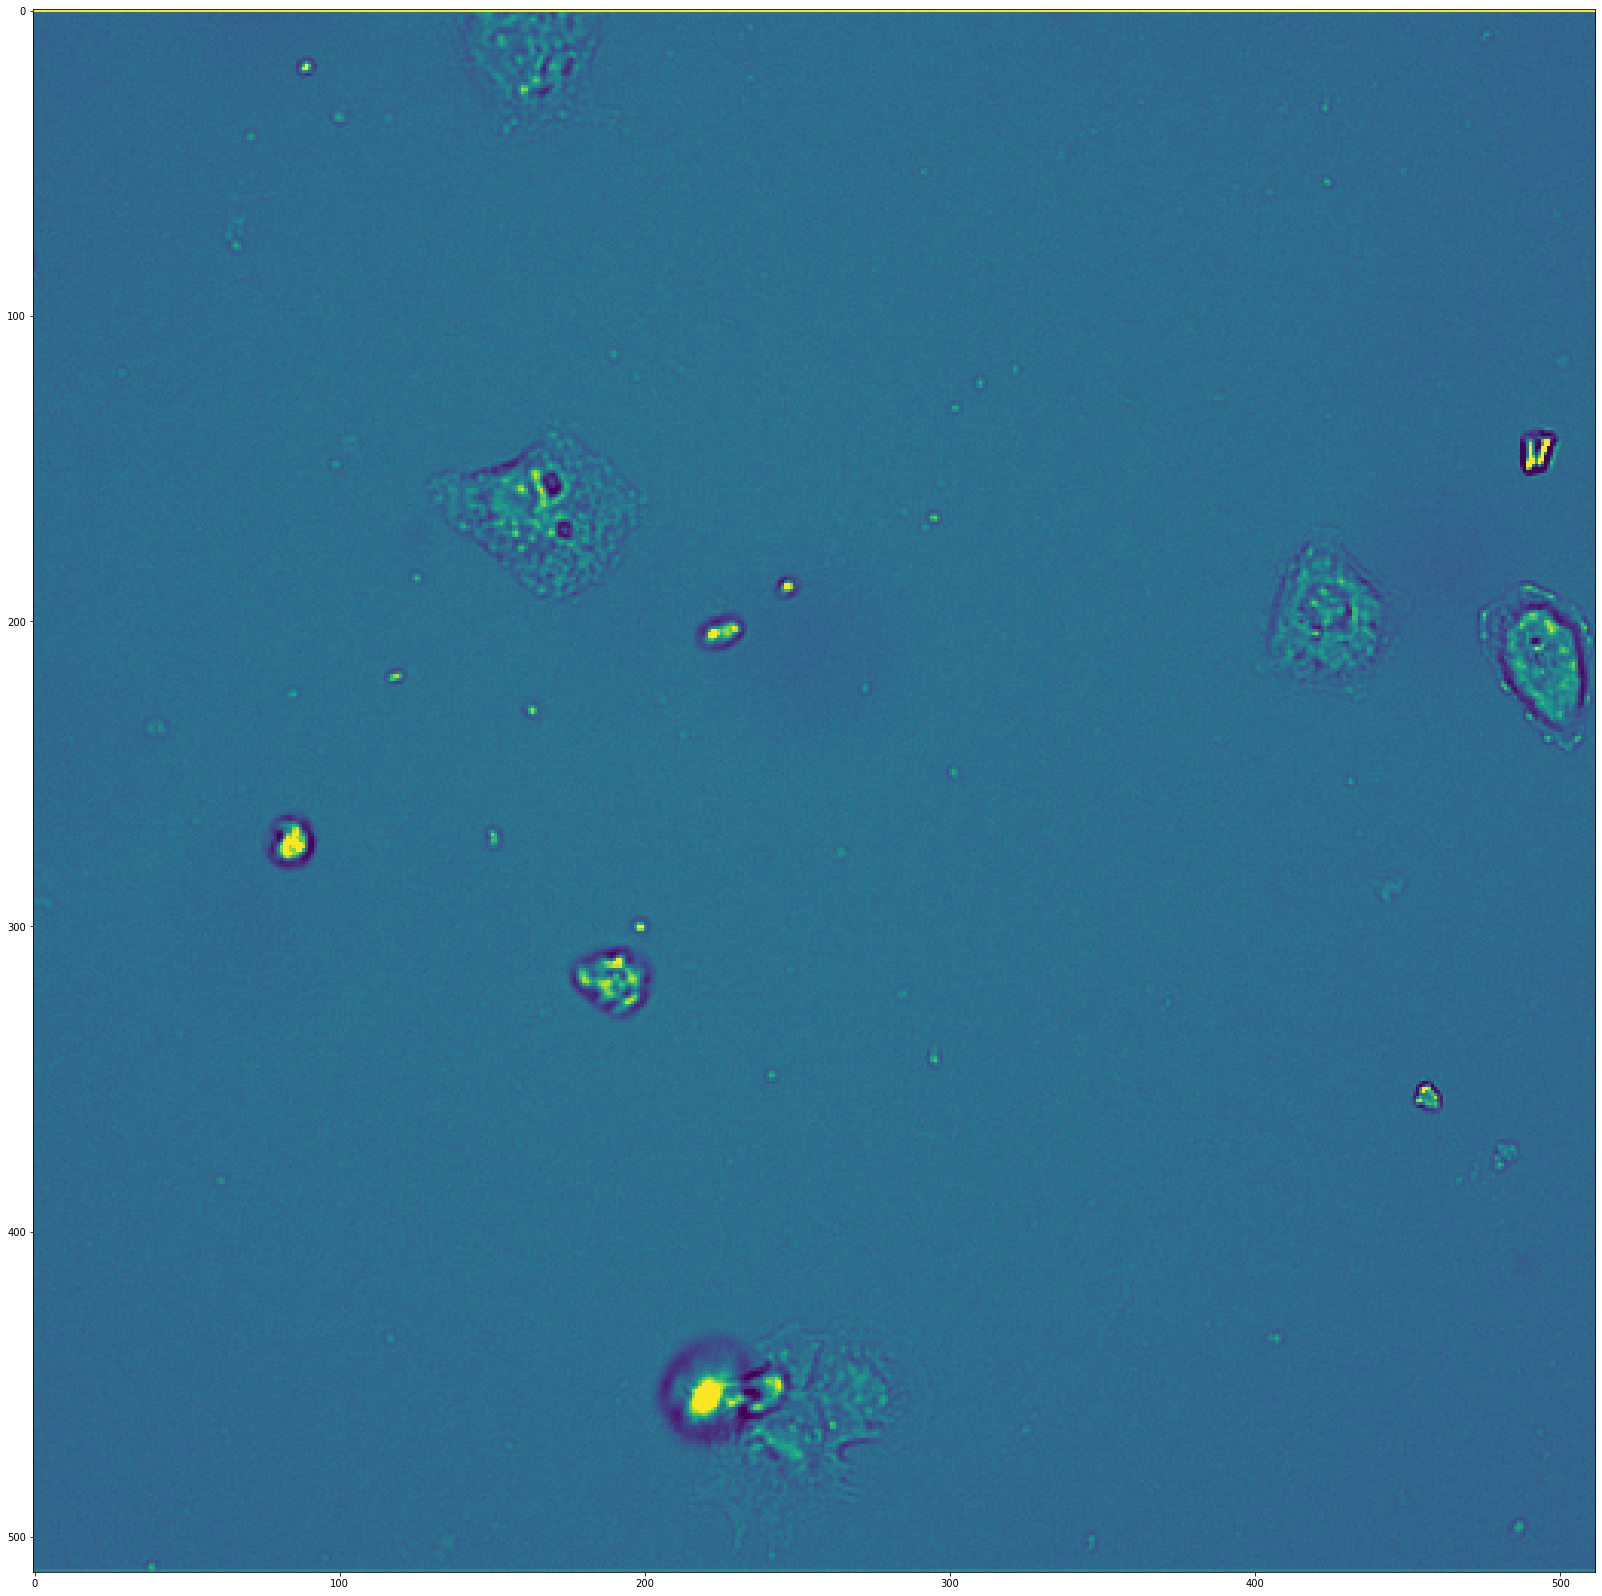

In [4]:
img0 = cv2.imread(imageNames[0])
frame1 = img0[::ds,::ds,:]
frame_ref = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
plt.imshow(frame_ref)

In [5]:
from scipy.ndimage.filters import generic_filter
import numpy as np

I_filt = generic_filter(frame_ref, np.std, size=11)


In [6]:
print(np.max(I_filt))
print(np.min(I_filt))
print(np.median(I_filt))
print(np.percentile(I_filt[:], 50))
print(np.percentile(I_filt[:], 80))
print(np.percentile(I_filt[:], 90))

98
2
3.0
3.0
3.0
7.0


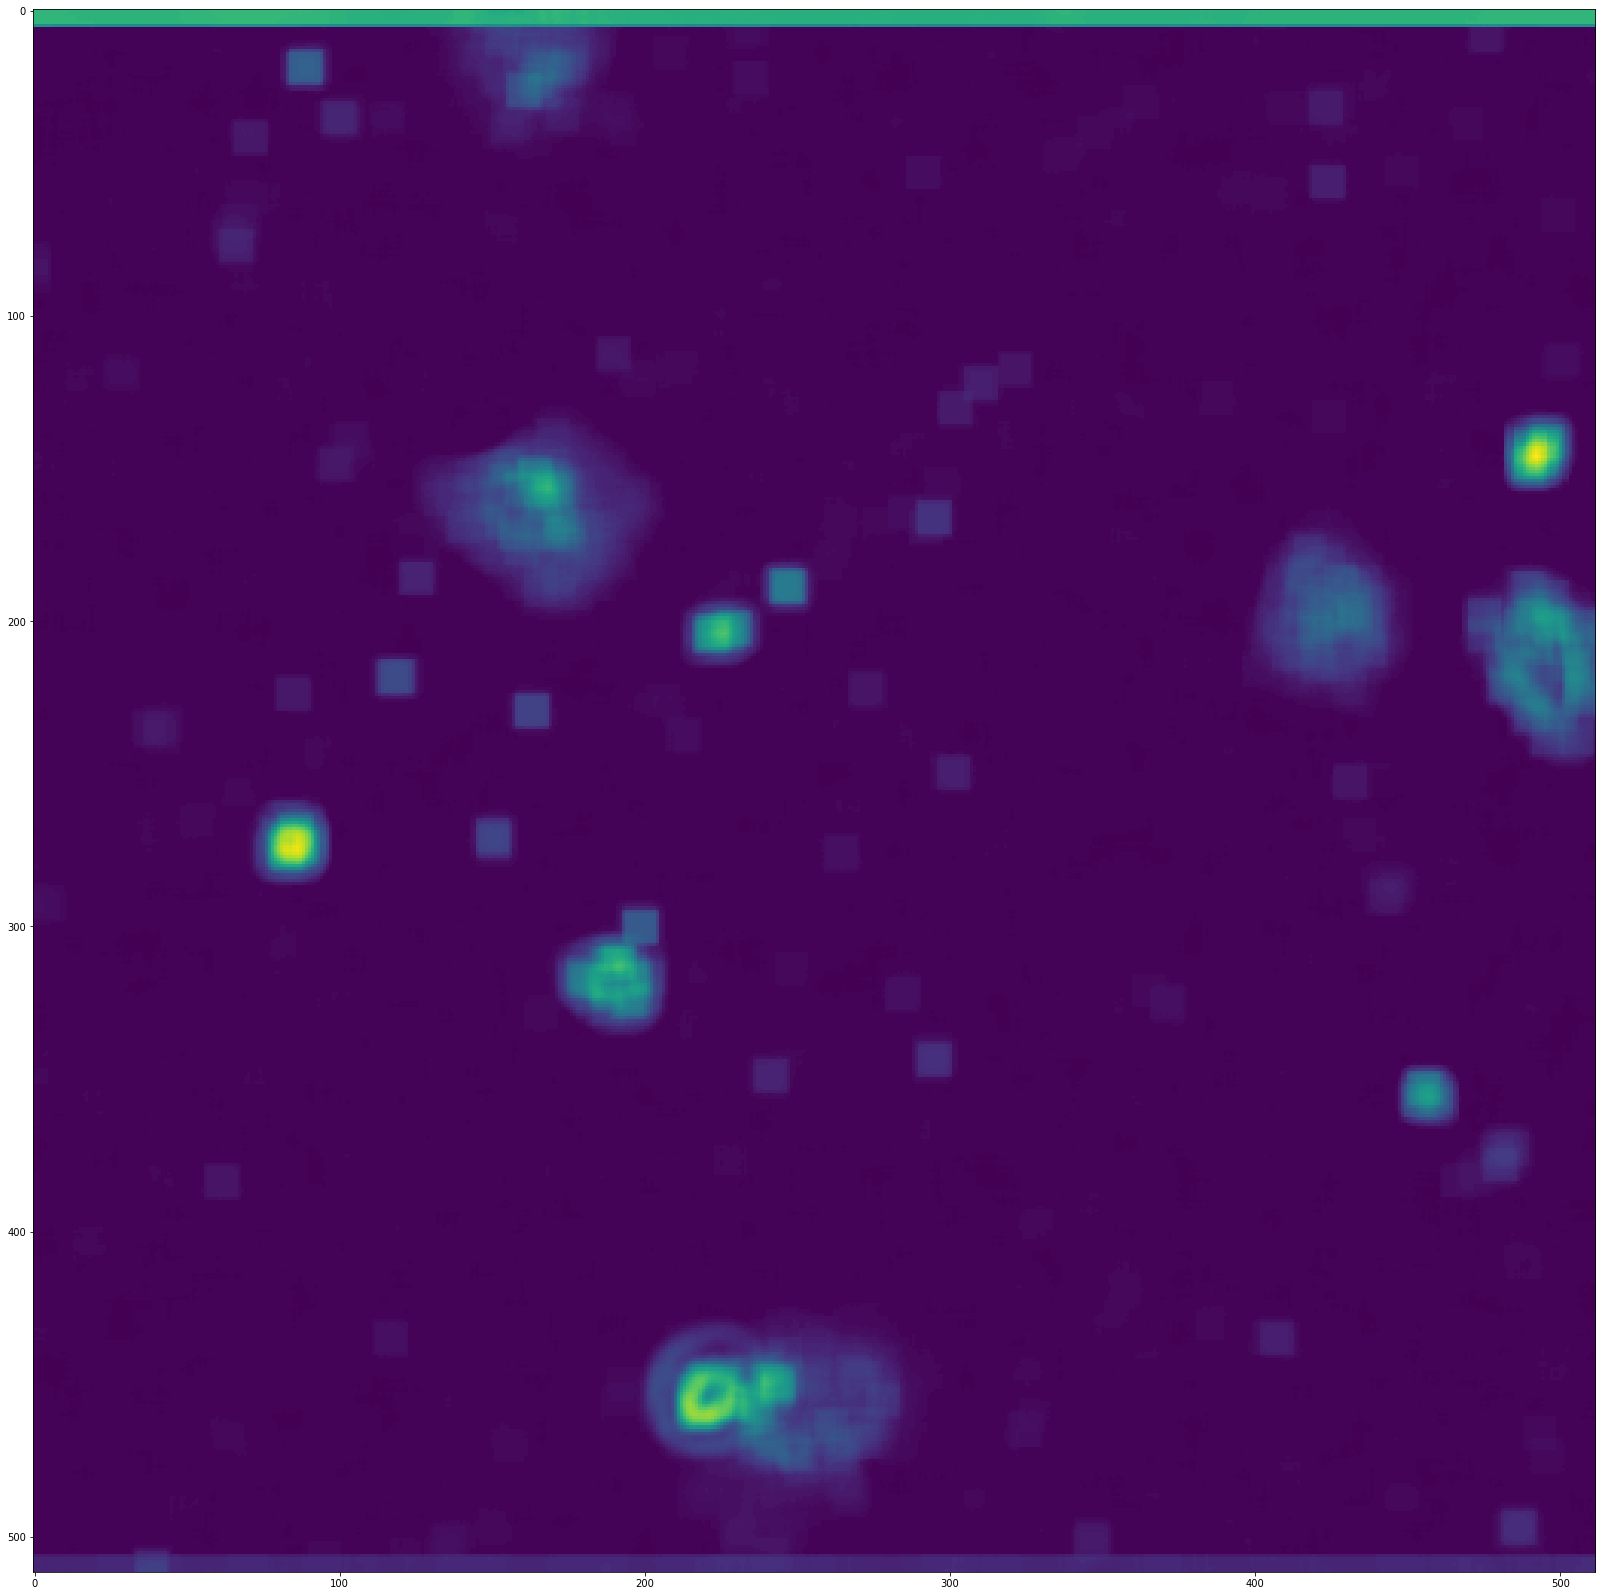

In [7]:
plt.imshow(I_filt)

(512, 512)


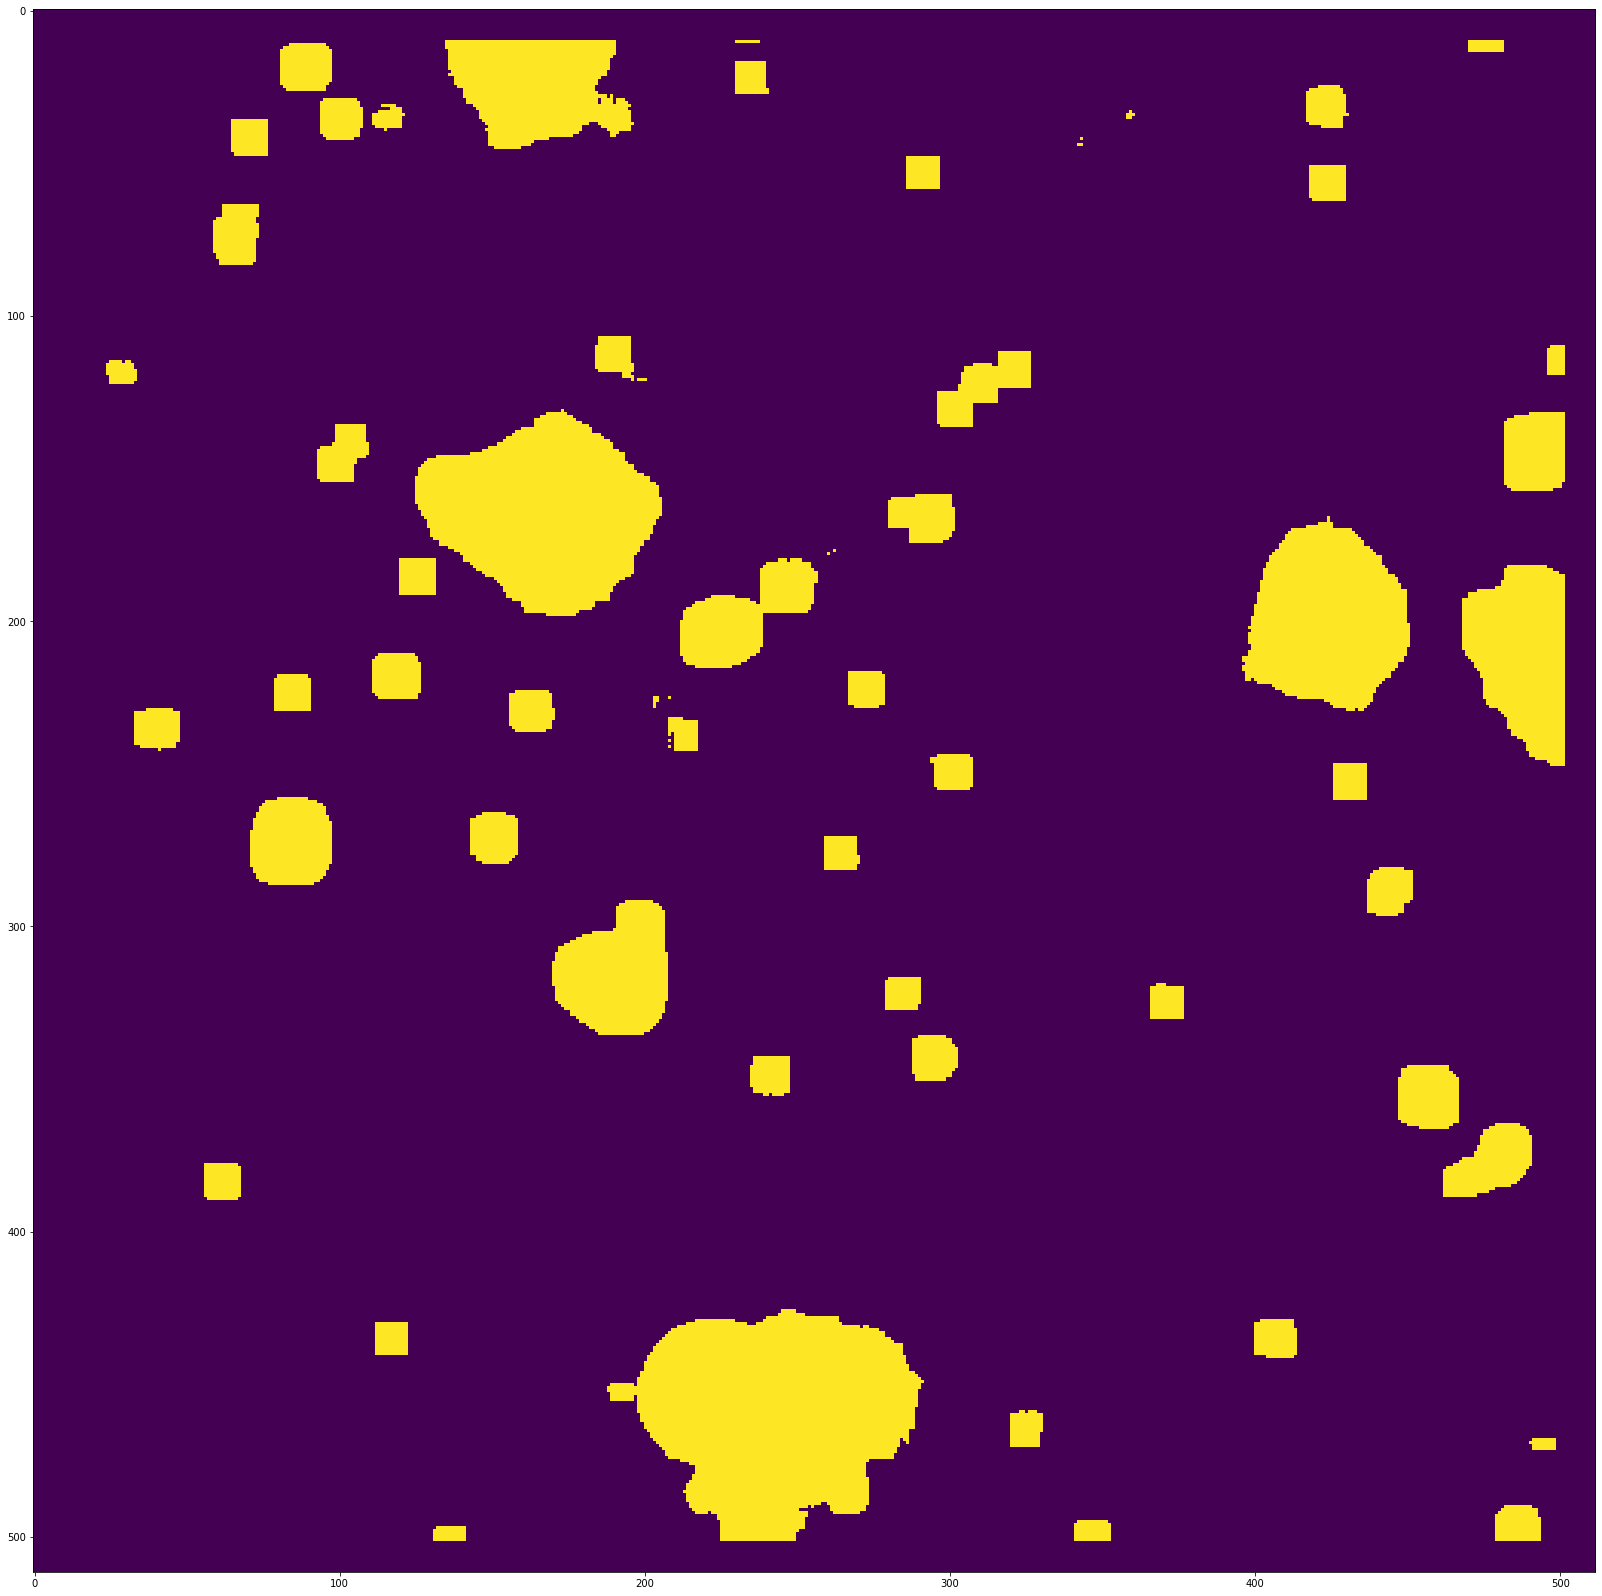

In [8]:
thresh = np.percentile(I_filt[:], 85)
valid_region = np.zeros(I_filt.shape)
print(valid_region.shape)
valid_region[10:-10,10:-10] = 1
I_filt = np.multiply(I_filt,valid_region)
result0 =  I_filt>thresh
plt.imshow(result0)

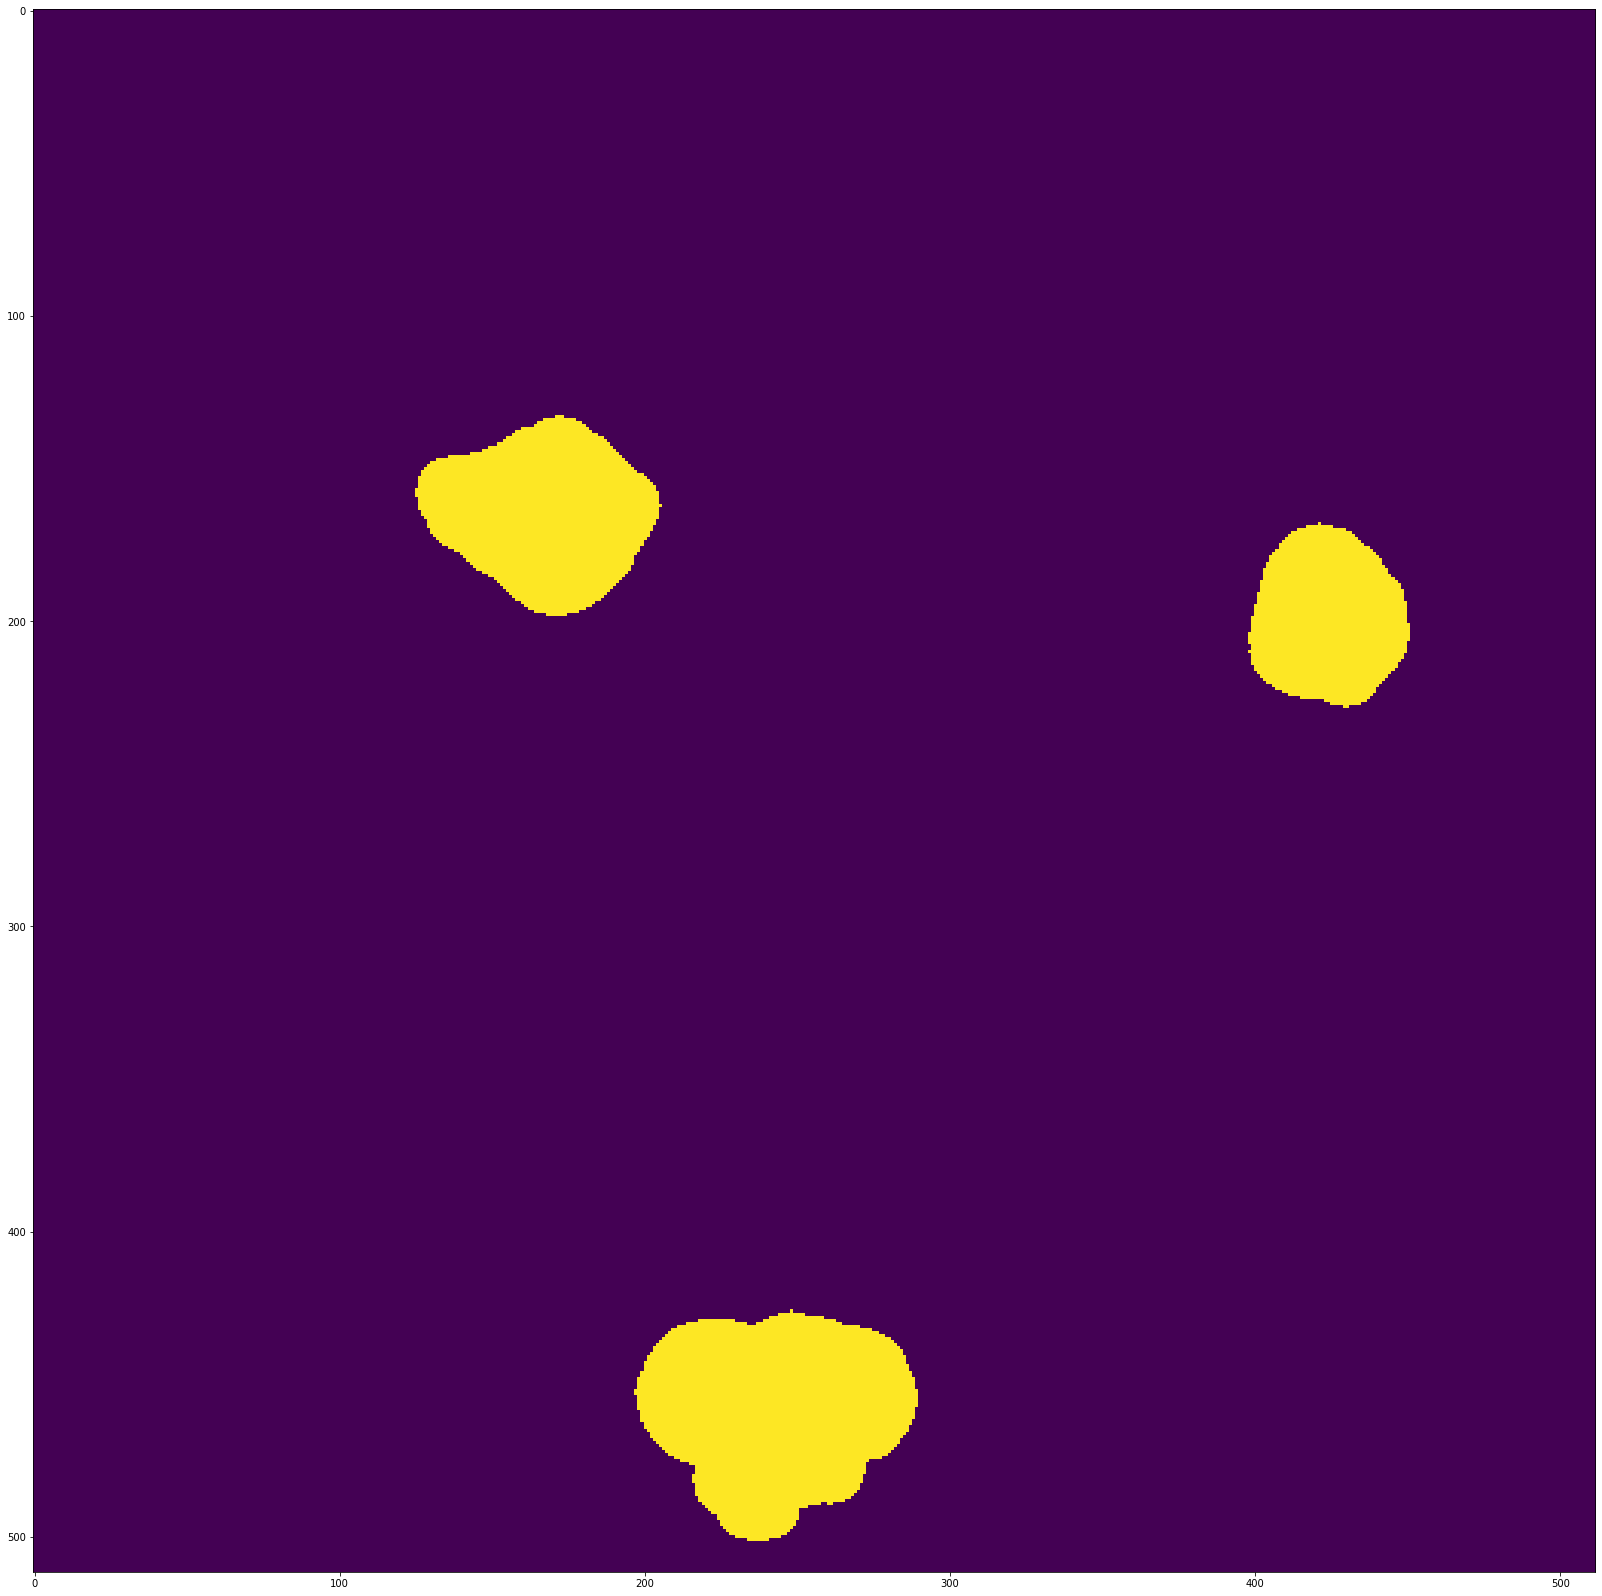

In [9]:
result1 = binary_opening(result0,disk(11))
result1 = remove_small_objects(result1,1500)
plt.imshow(result1)

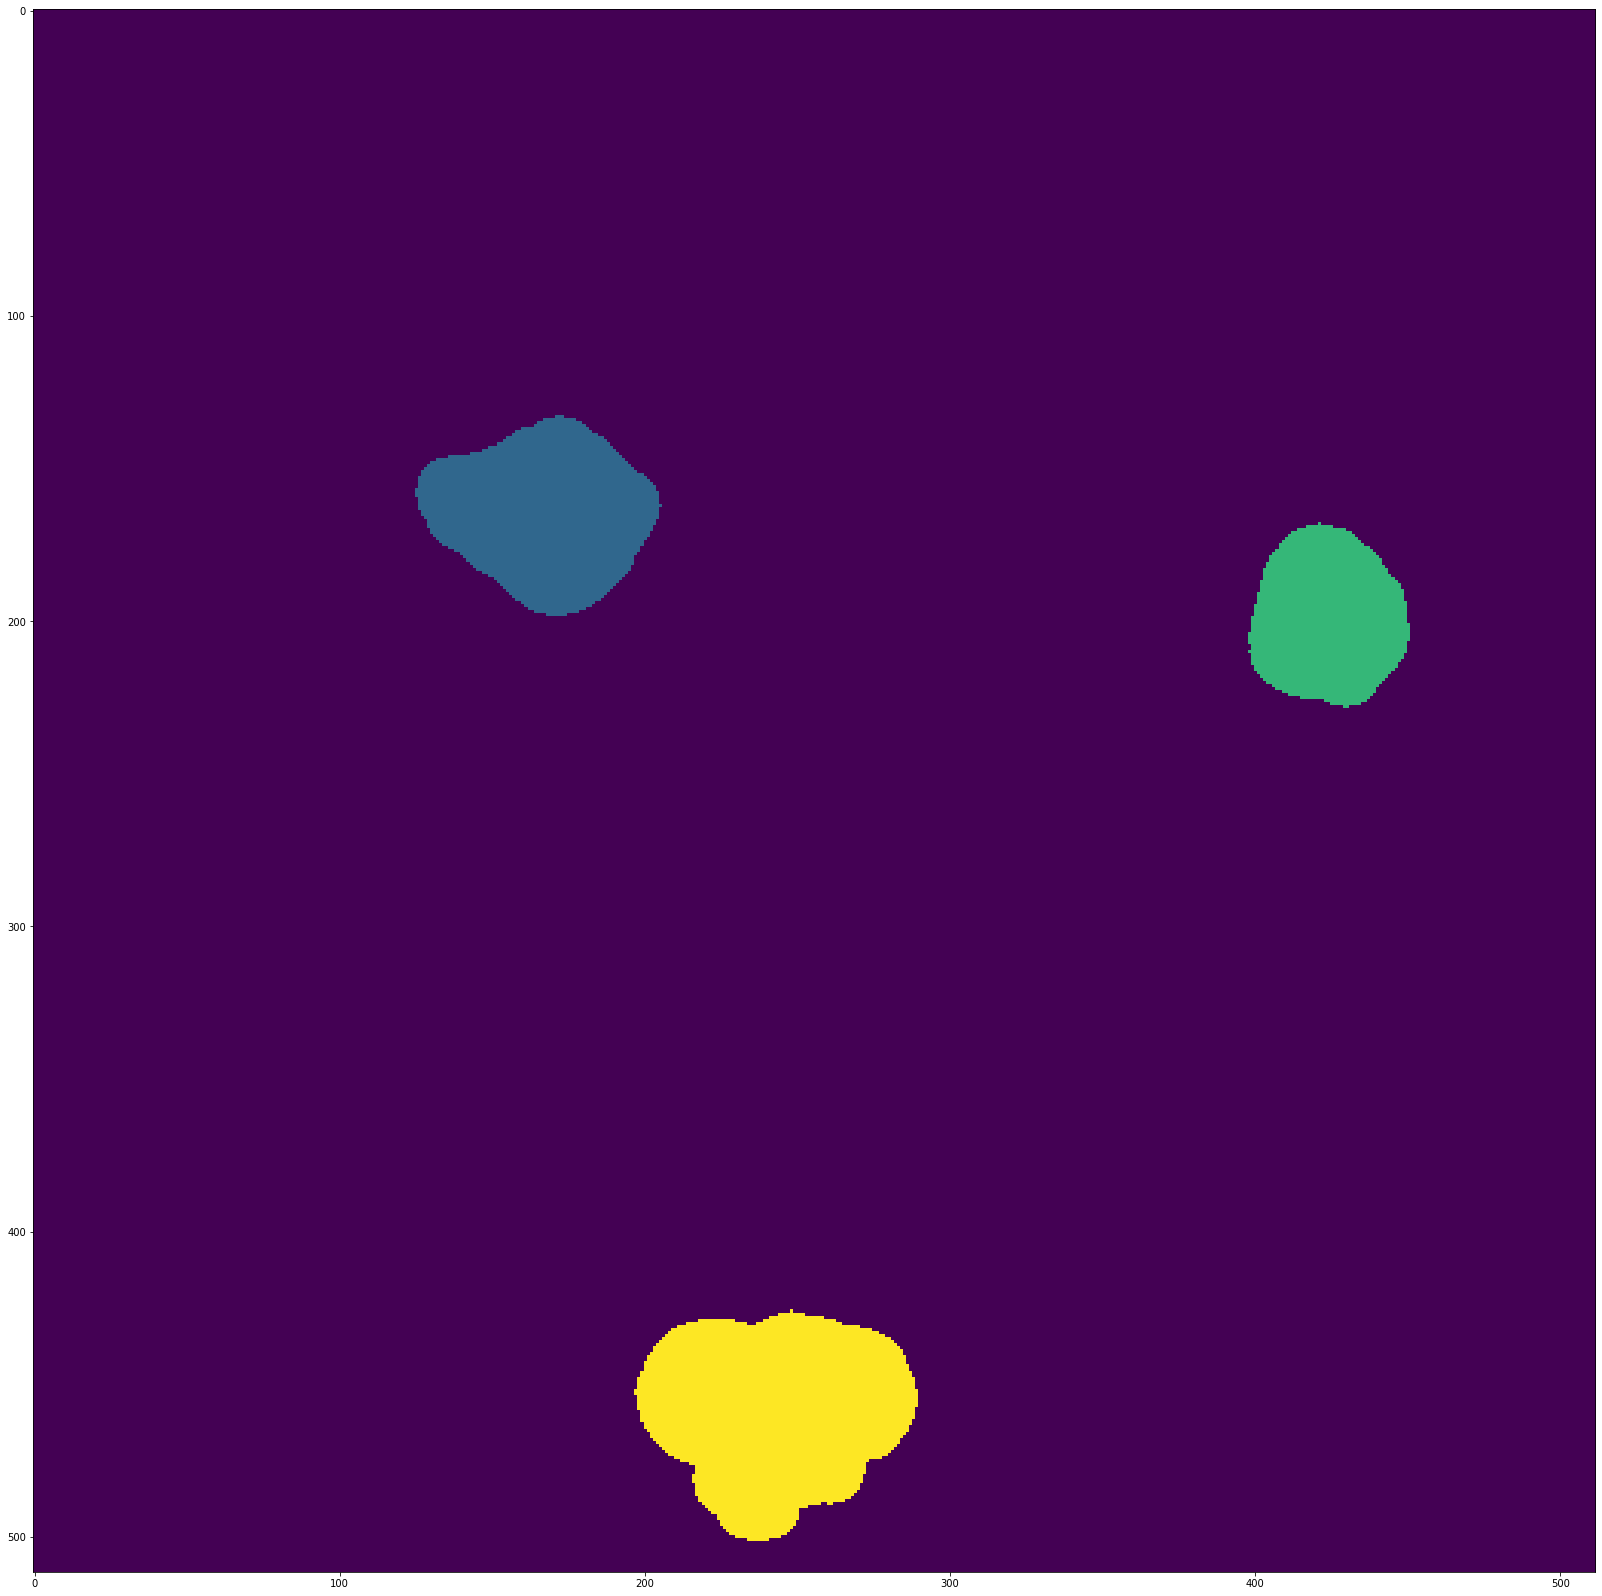

In [10]:
mask_label = label(result1)
plt.imshow(mask_label)

[]
0
0
0
0


Text(0, 0, '5')

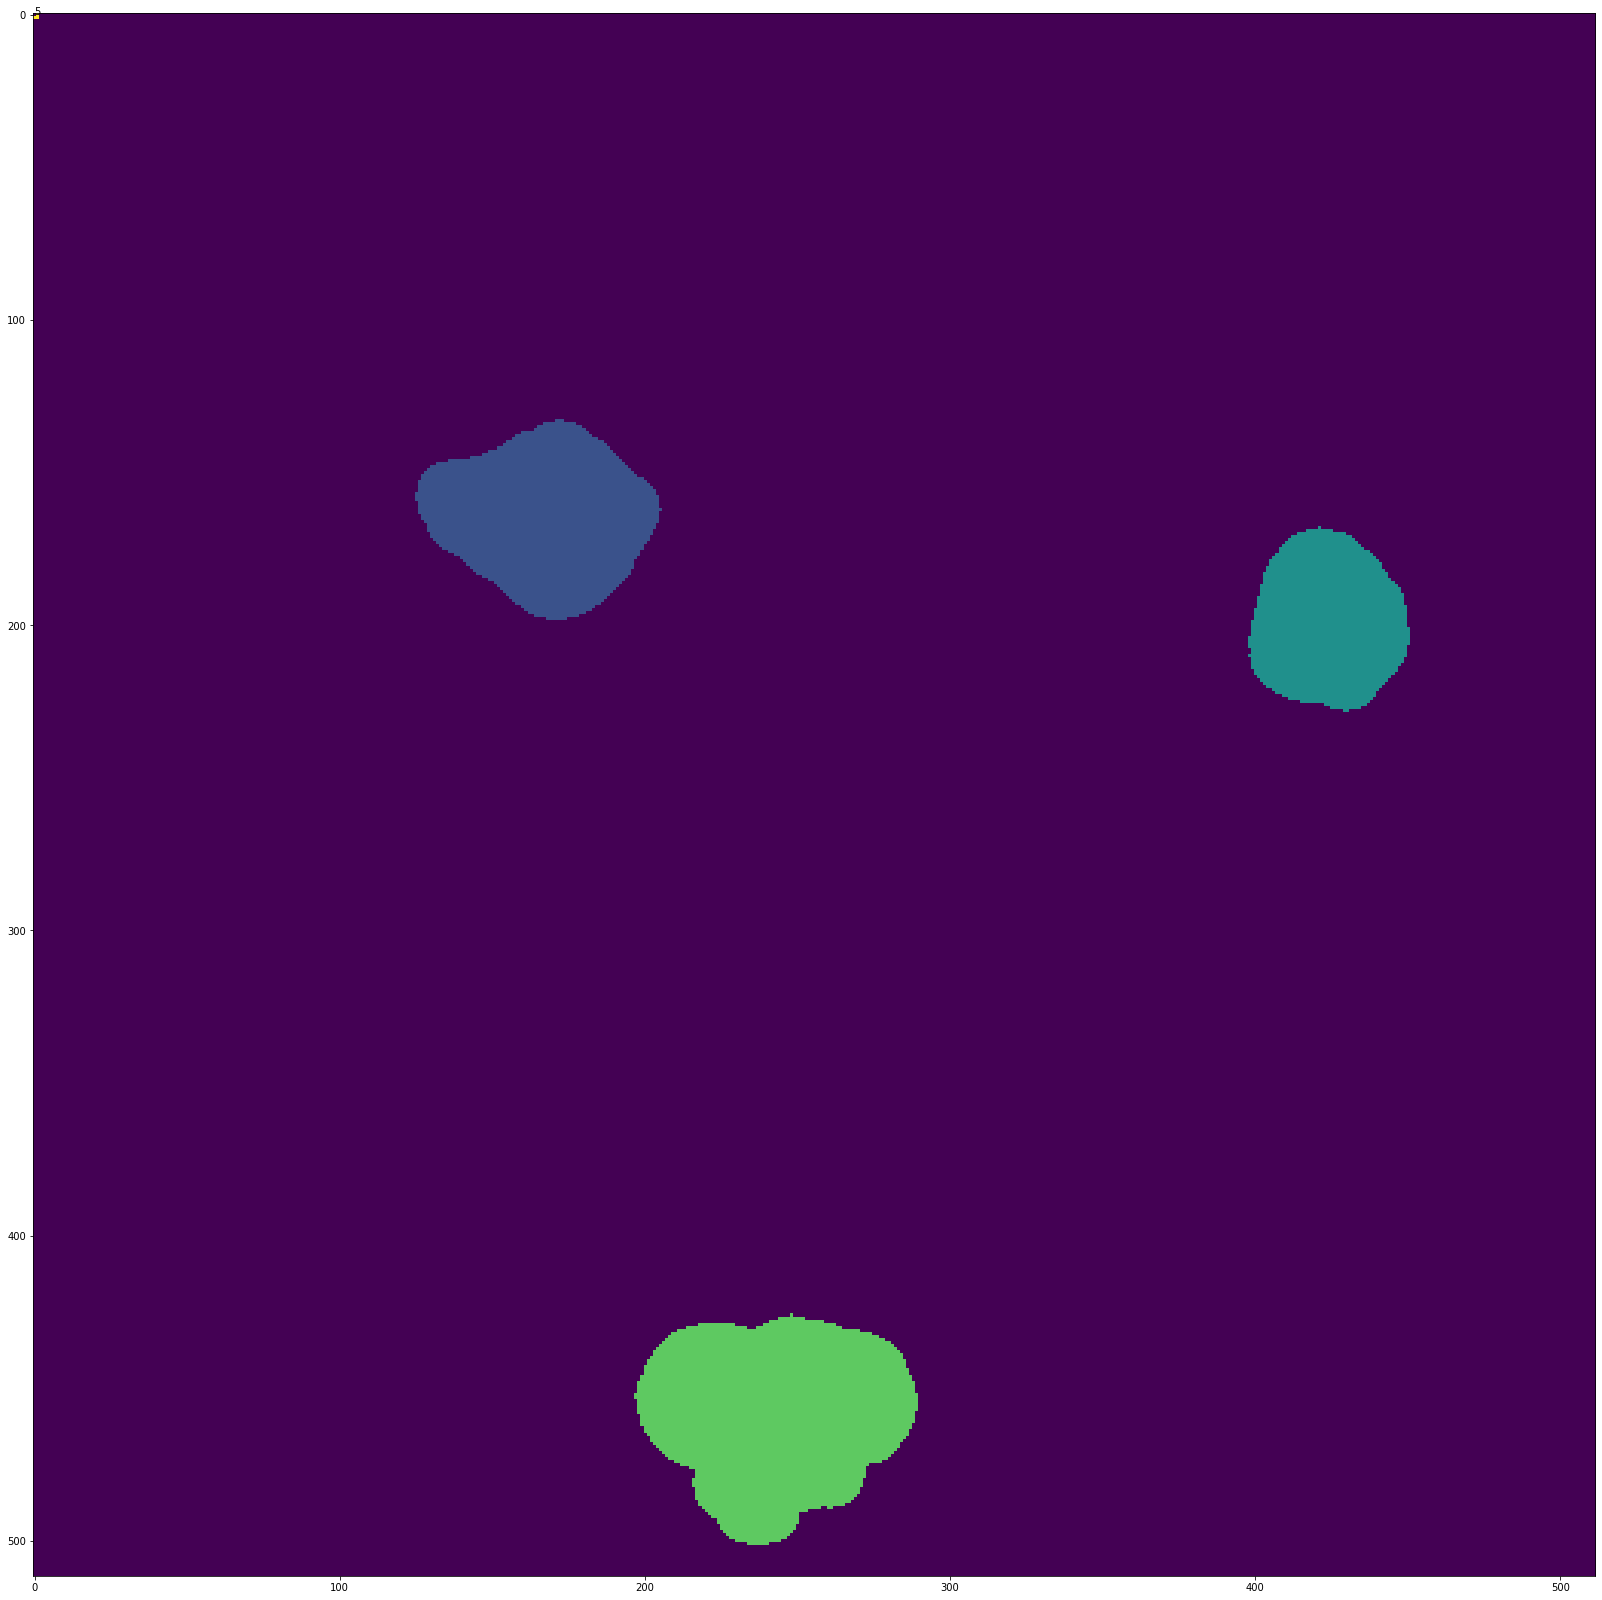

In [11]:
from skimage.draw import rectangle_perimeter
active_px = np.argwhere(mask_label==6)
###active_px = active_px[:,[1,0]]
print(active_px)
x,y,w,h = cv2.boundingRect(active_px)
rr, cc = rectangle_perimeter(start=(x,y), end=(x+w,y+h), shape=mask_label.shape)
mask_label[rr, cc] = np.max(mask_label[:]+1)
frame_display= frame1
frame_display[rr,cc,:]=255

print(x)
print(y)
print(w)
print(h)
plt.imshow(mask_label)
plt.text(int(x-w/2), int(y-h/2),str(5))

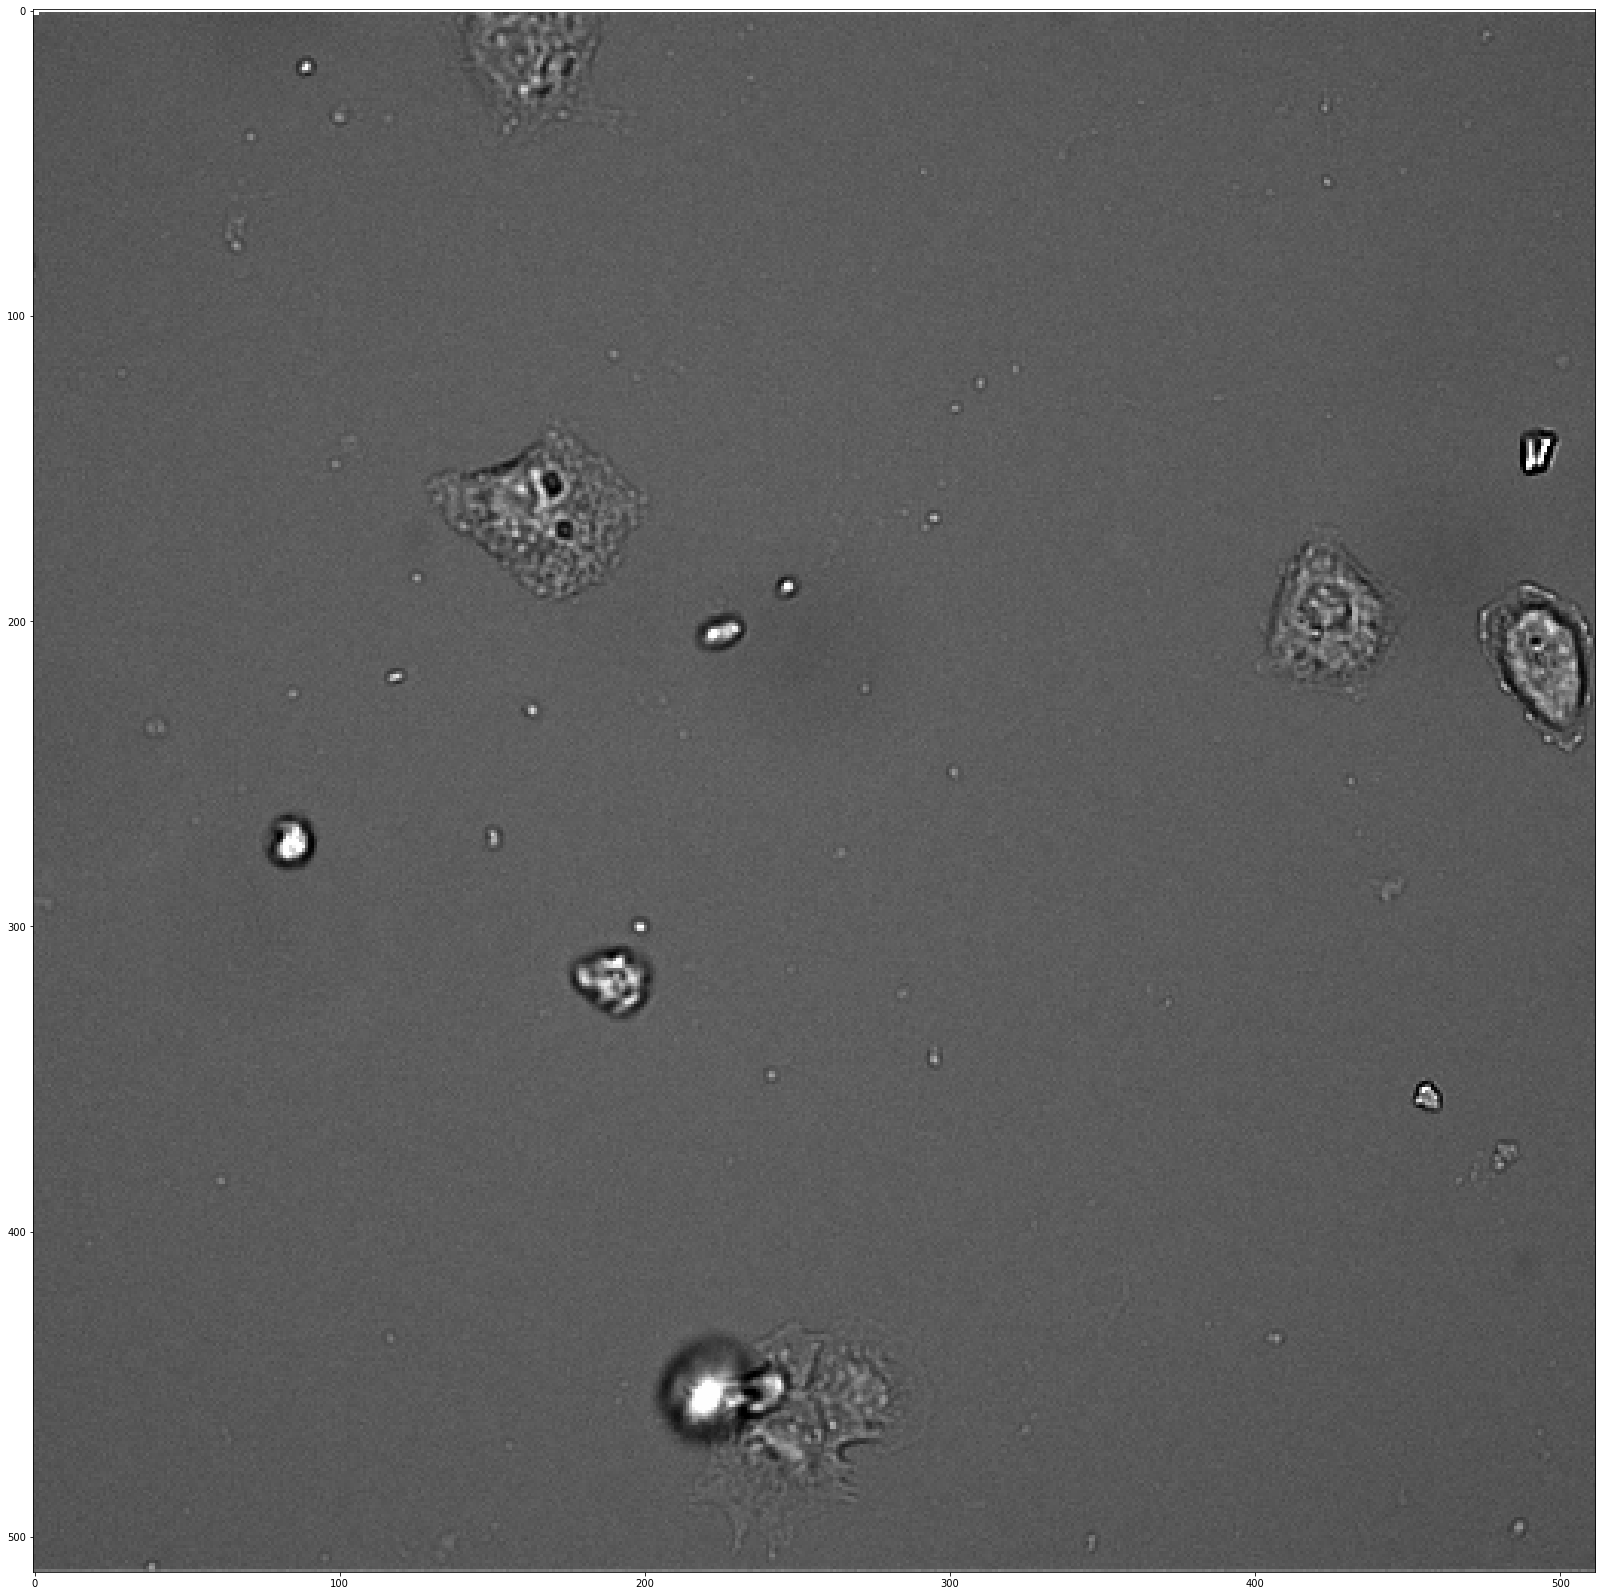

In [12]:
plt.imshow(frame_display)

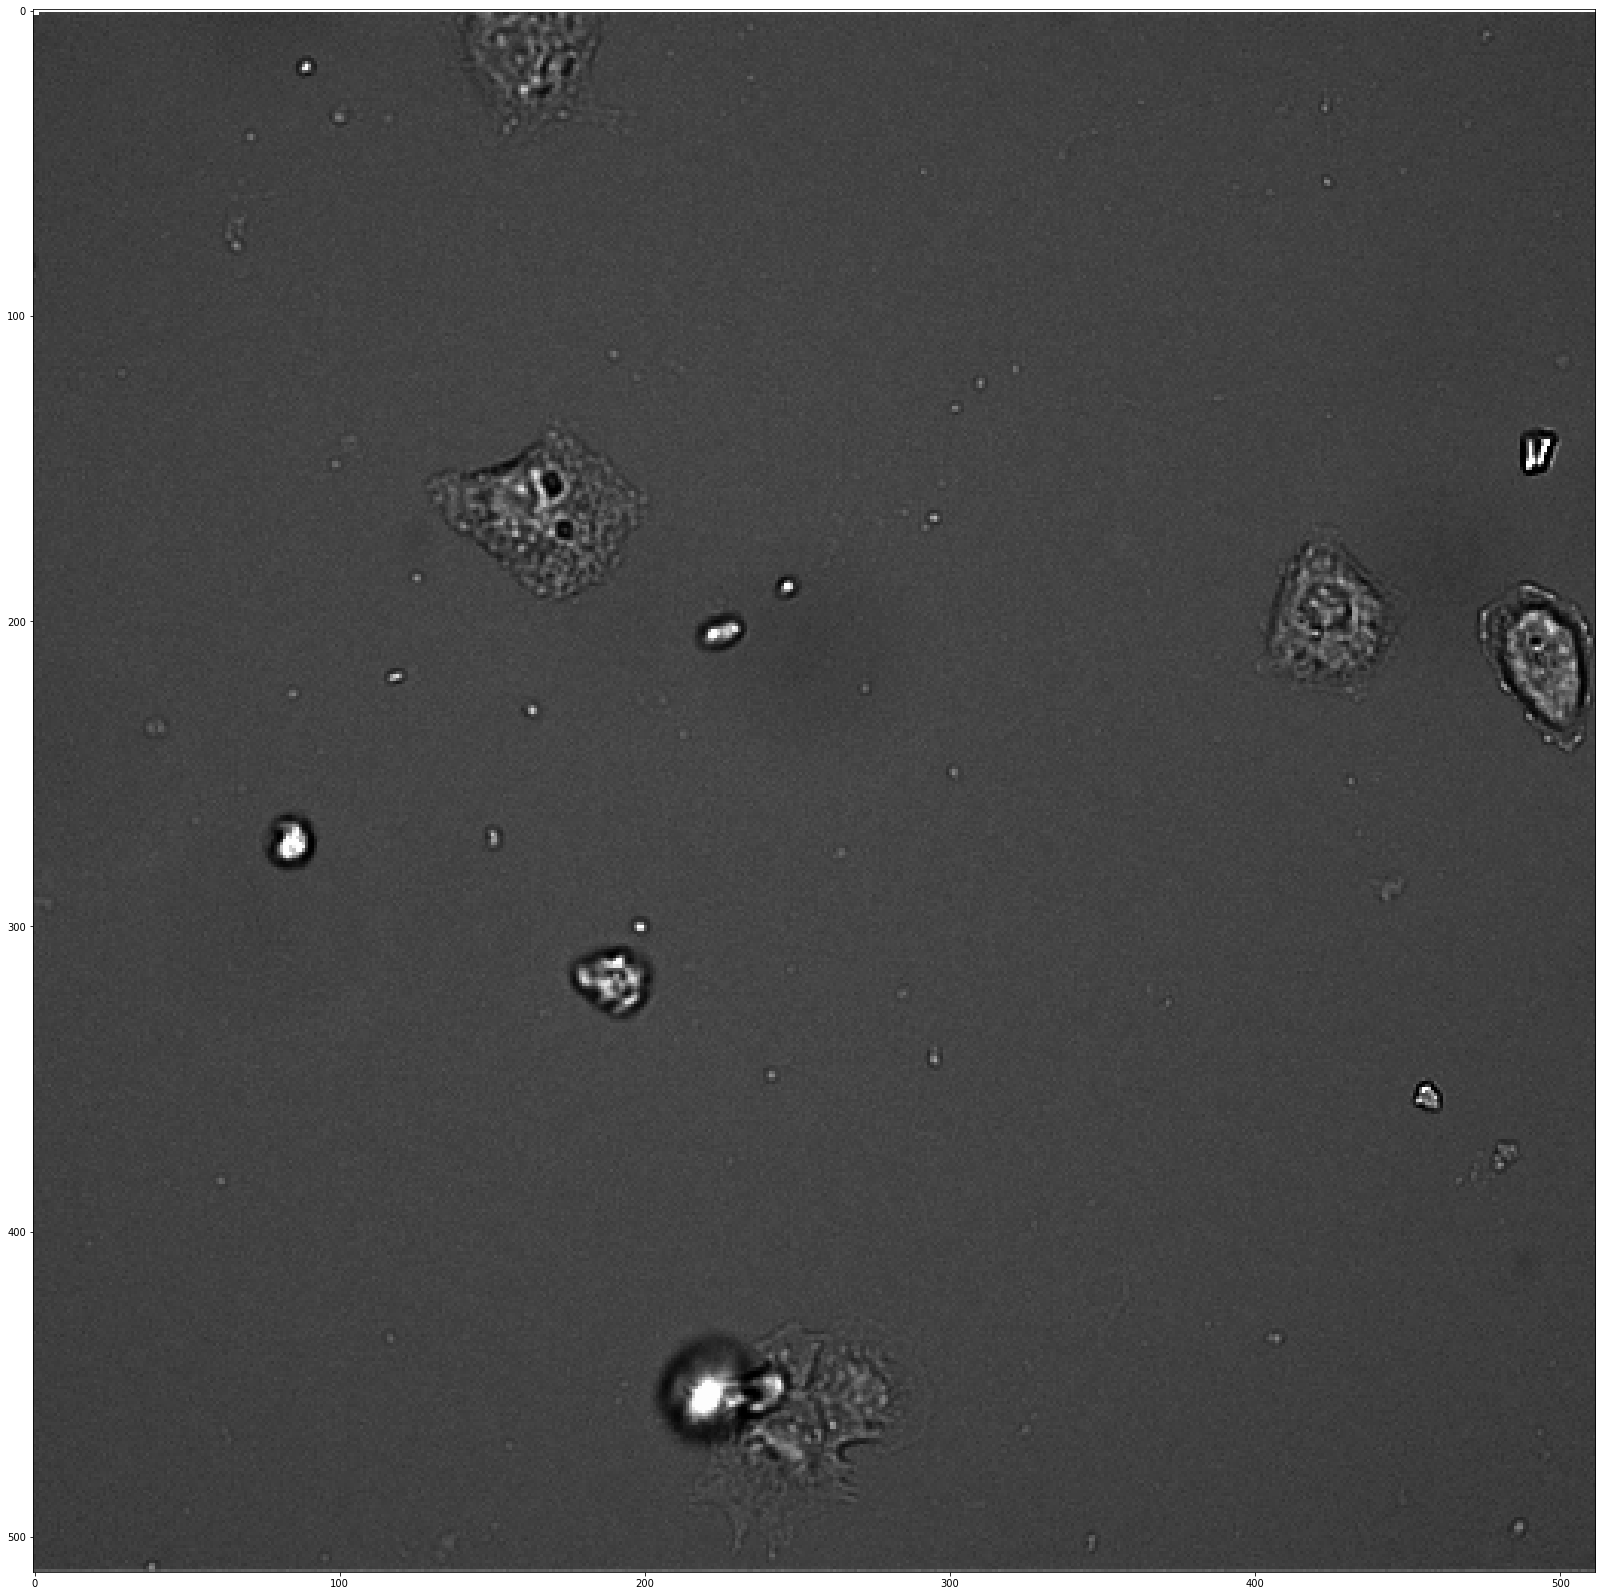

In [13]:
from skimage import data, exposure, img_as_float
gamma_corrected = exposure.adjust_gamma(frame_display, 1.3)
plt.imshow(gamma_corrected)

In [14]:
print(magStack.shape)


(512, 512, 1456)


In [15]:
print(np.percentile(magStack,50))

0.08861541748046875


In [16]:
print(np.percentile(magStack,90))

0.20007441937923431


In [17]:
print(np.percentile(magStack,10))
print(np.percentile(magStack,5))
th = np.percentile(magStack,5)

0.02882278524339199
0.01899907924234867


In [19]:
th = np.percentile(magStack,1)
magStack_soft = magStack<th

magStack1= np.multiply(magStack, magStack_soft.astype(int))
print(sum(sum(sum(magStack1[:]))))

16982.546335504743


In [20]:
th = np.percentile(magStack,5)
magStack_soft = magStack<th

magStack1= np.multiply(magStack, magStack_soft.astype(int))
print(sum(sum(sum(magStack1[:]))))

227202.5154745624


In [21]:
th = np.percentile(magStack,10)
magStack_soft = magStack<th

magStack1= np.multiply(magStack, magStack_soft.astype(int))
print(sum(sum(sum(magStack1[:]))))

687333.1276810998


In [45]:
active_px = np.argwhere(mask_label==2)
print(active_px)
aa = mask_label[active_px[:,0],active_px[:,1]]
bb = magStack[active_px[:,0],active_px[:,1],:]
print(aa)
print(aa.shape)
print(bb.shape)
cc = np.mean(bb,axis=0)
dd = np.percentile(bb,95,axis=0)
ee = np.percentile(bb,50,axis=0)
print(cc.shape)
print(dd.shape)

[[168 421]
 [169 417]
 [169 418]
 ...
 [227 434]
 [228 429]
 [228 430]]
[2 2 2 ... 2 2 2]
(2389,)
(2389, 1456)
(1456,)
(1456,)


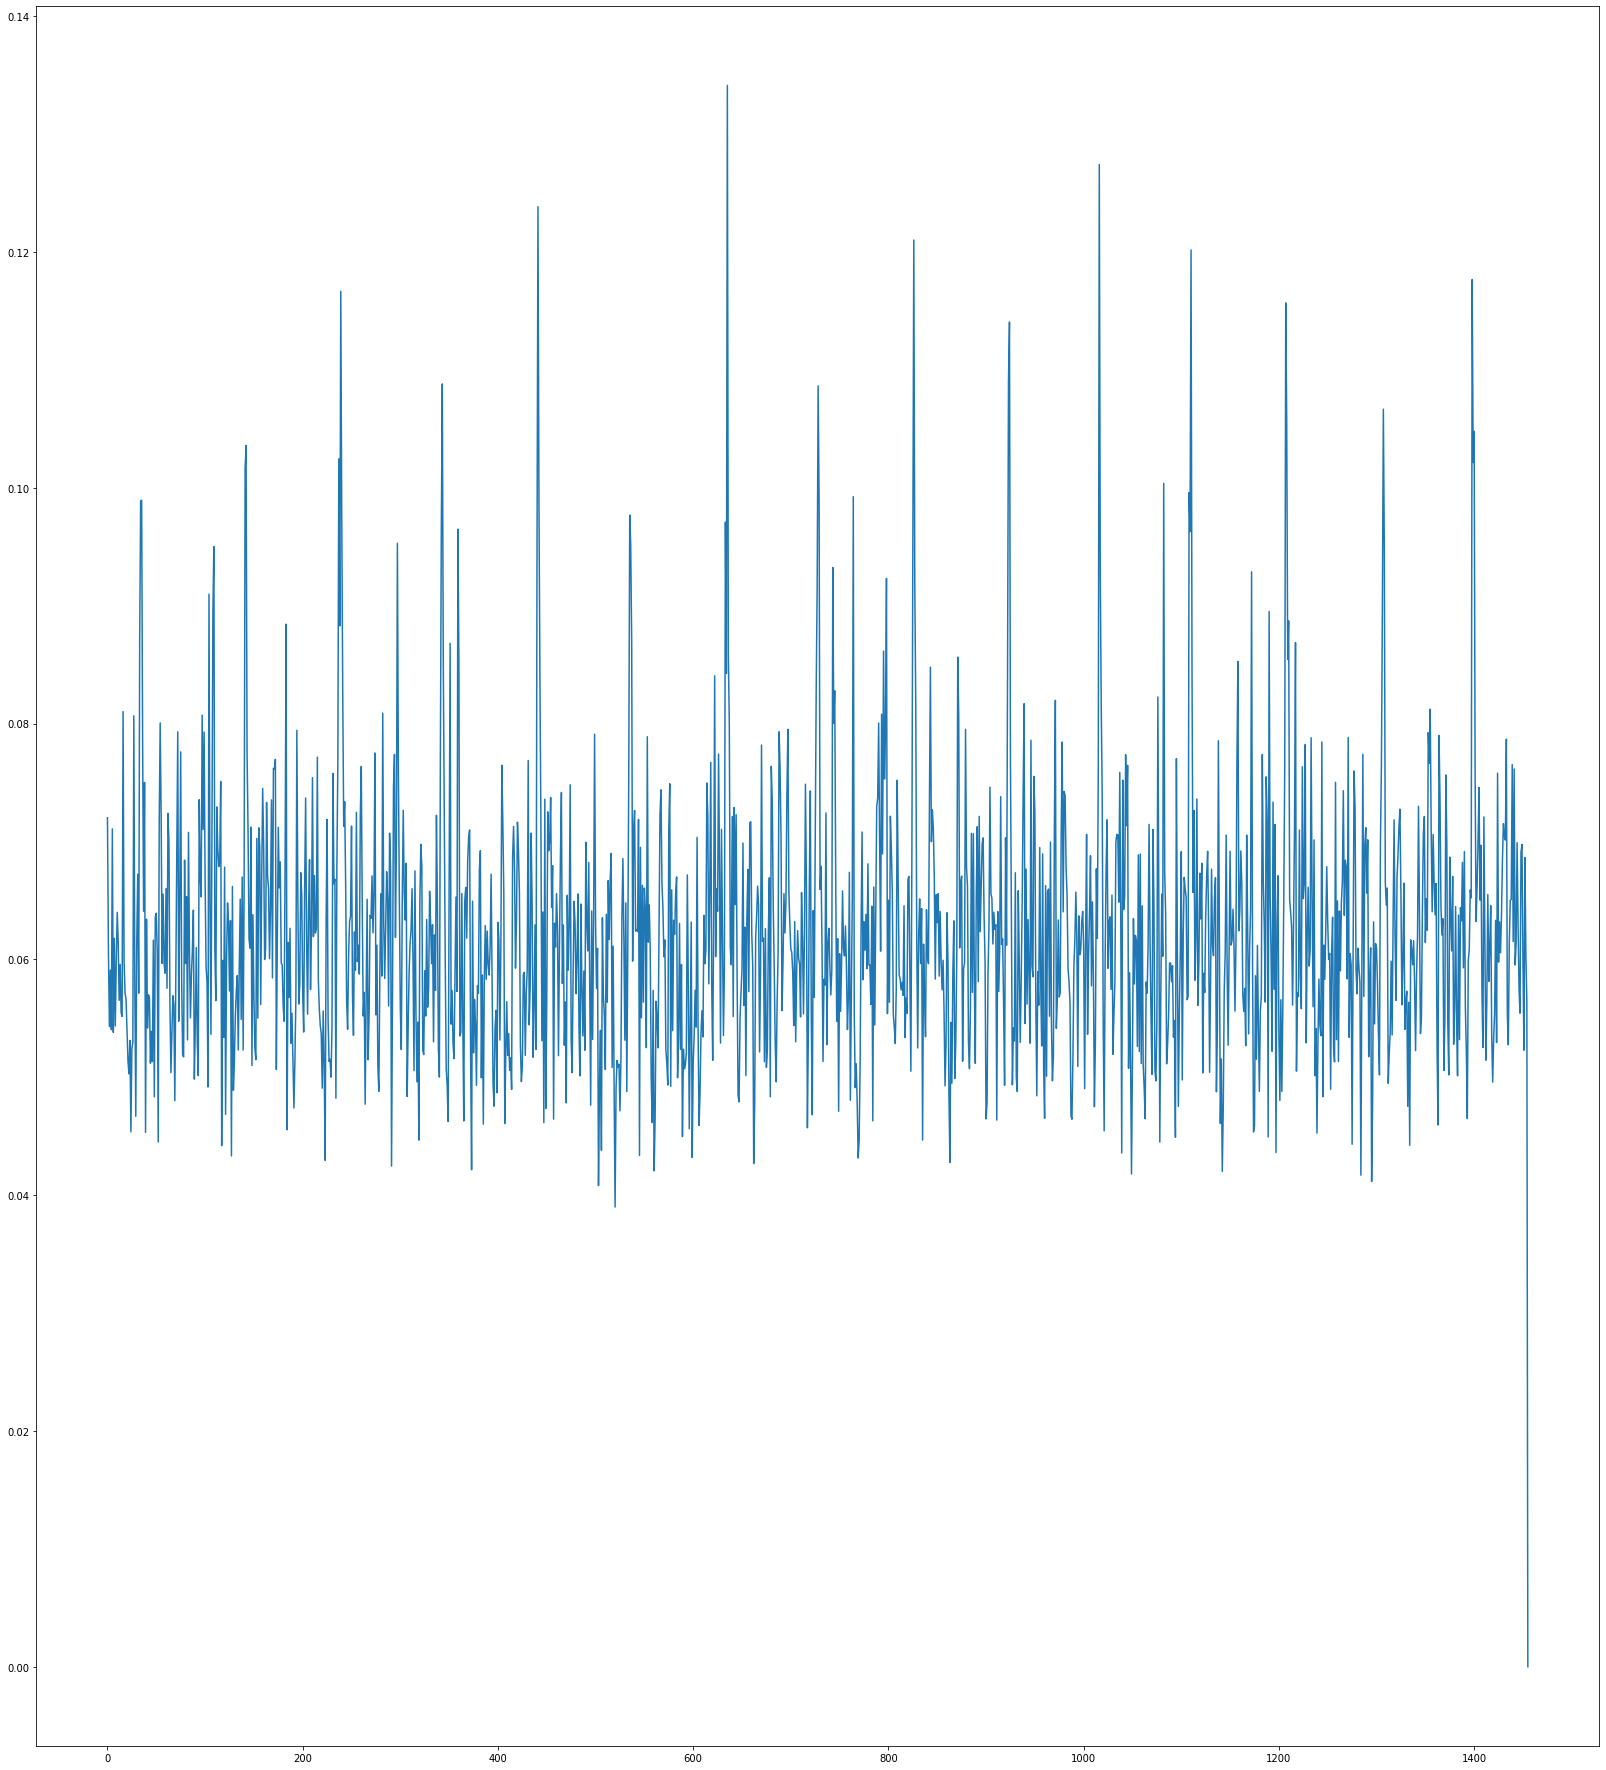

In [46]:
plt.plot(cc)

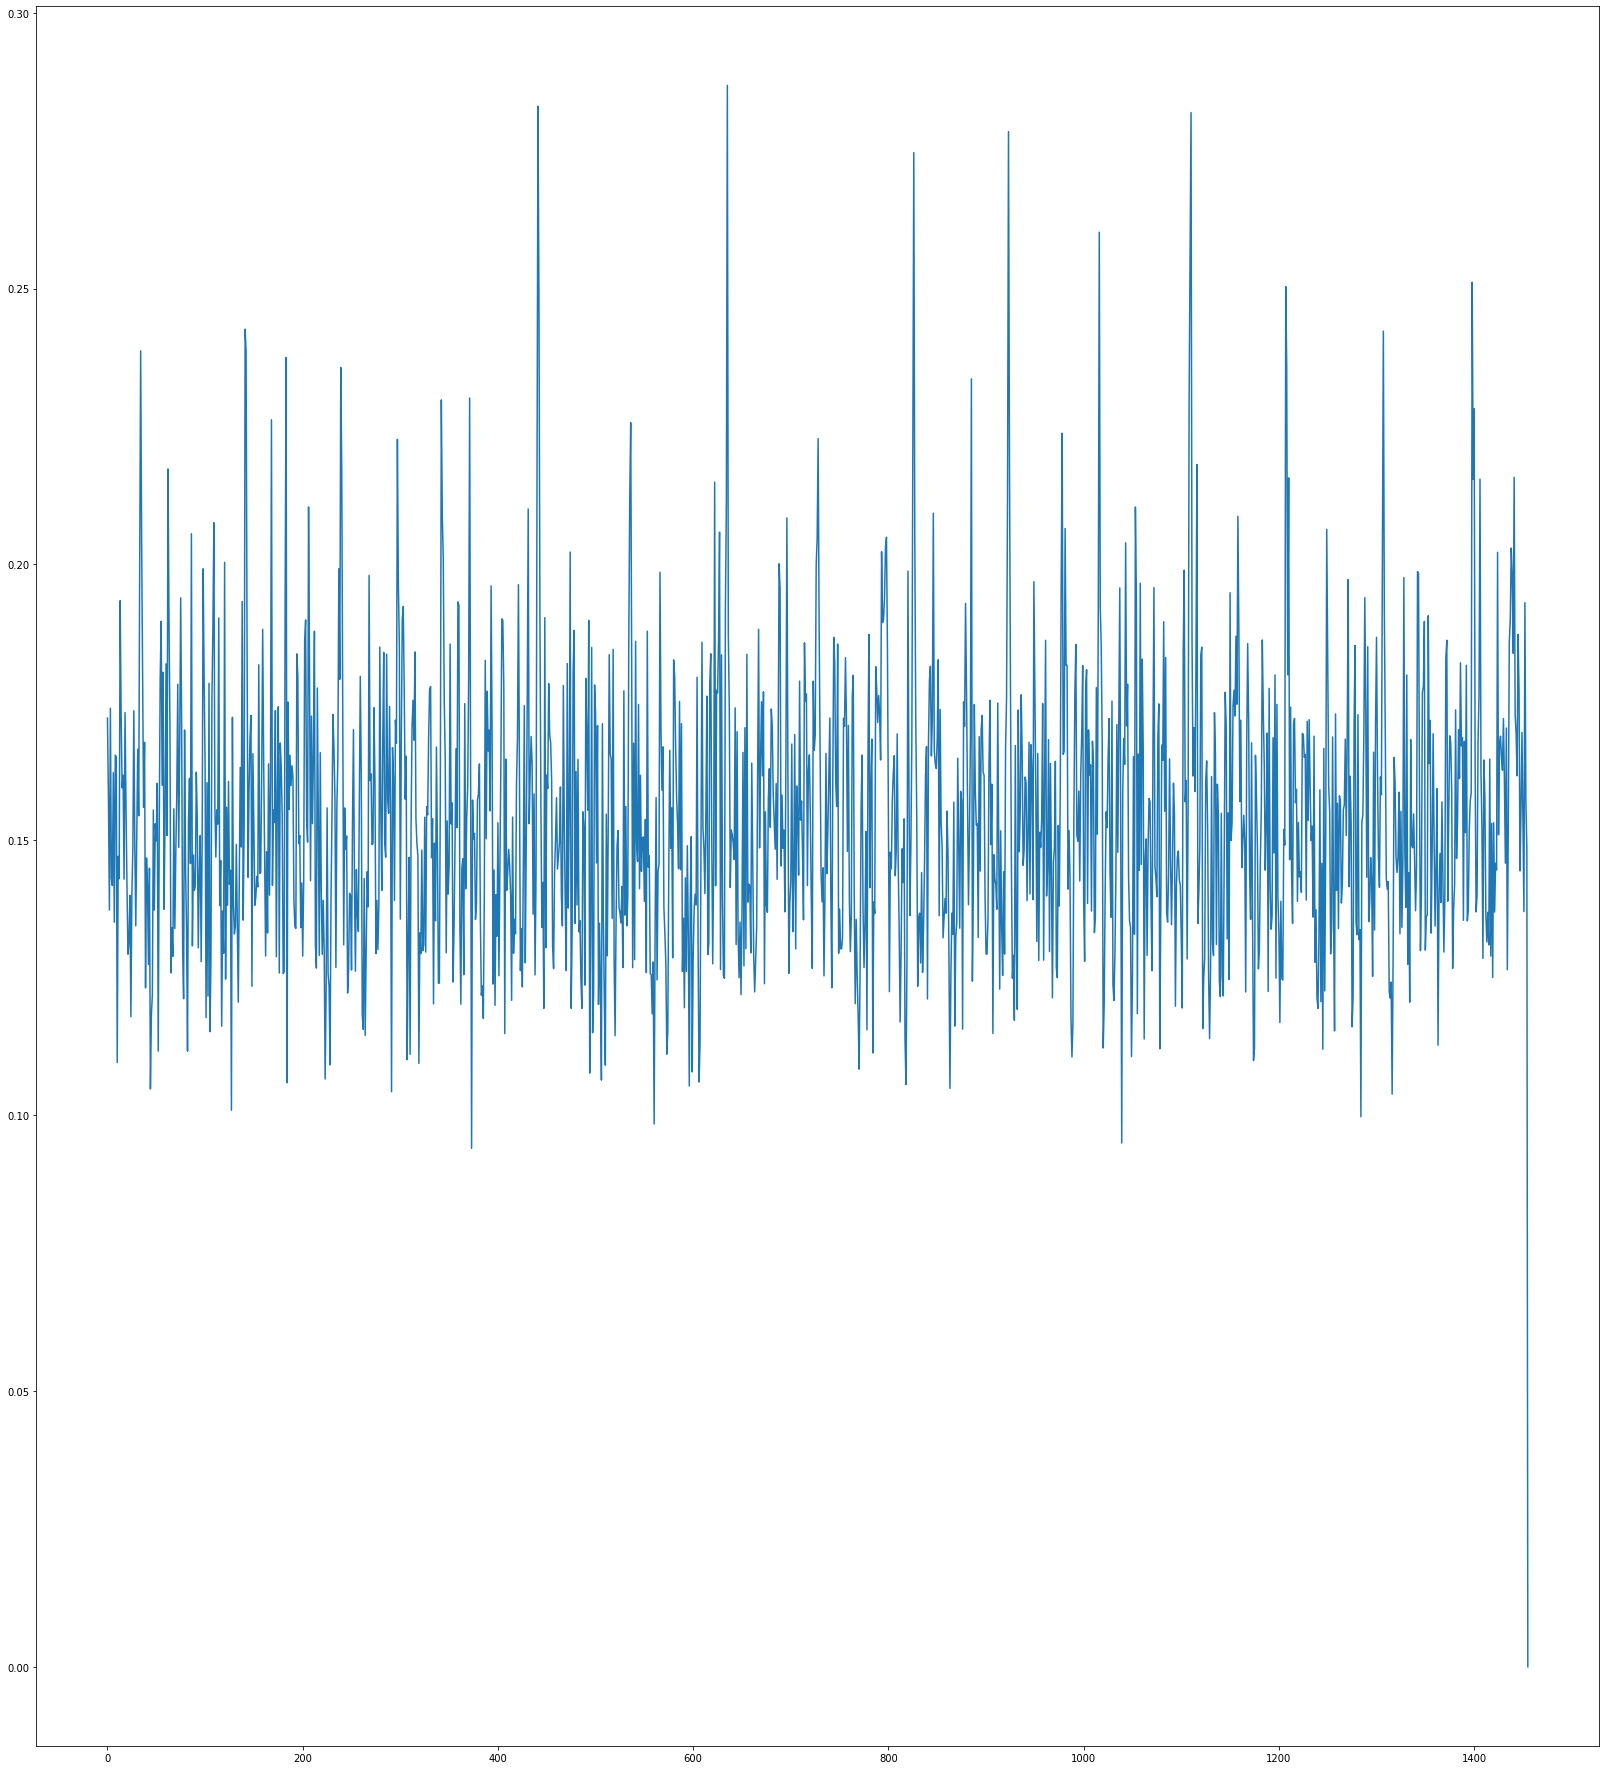

In [47]:
plt.plot(dd)

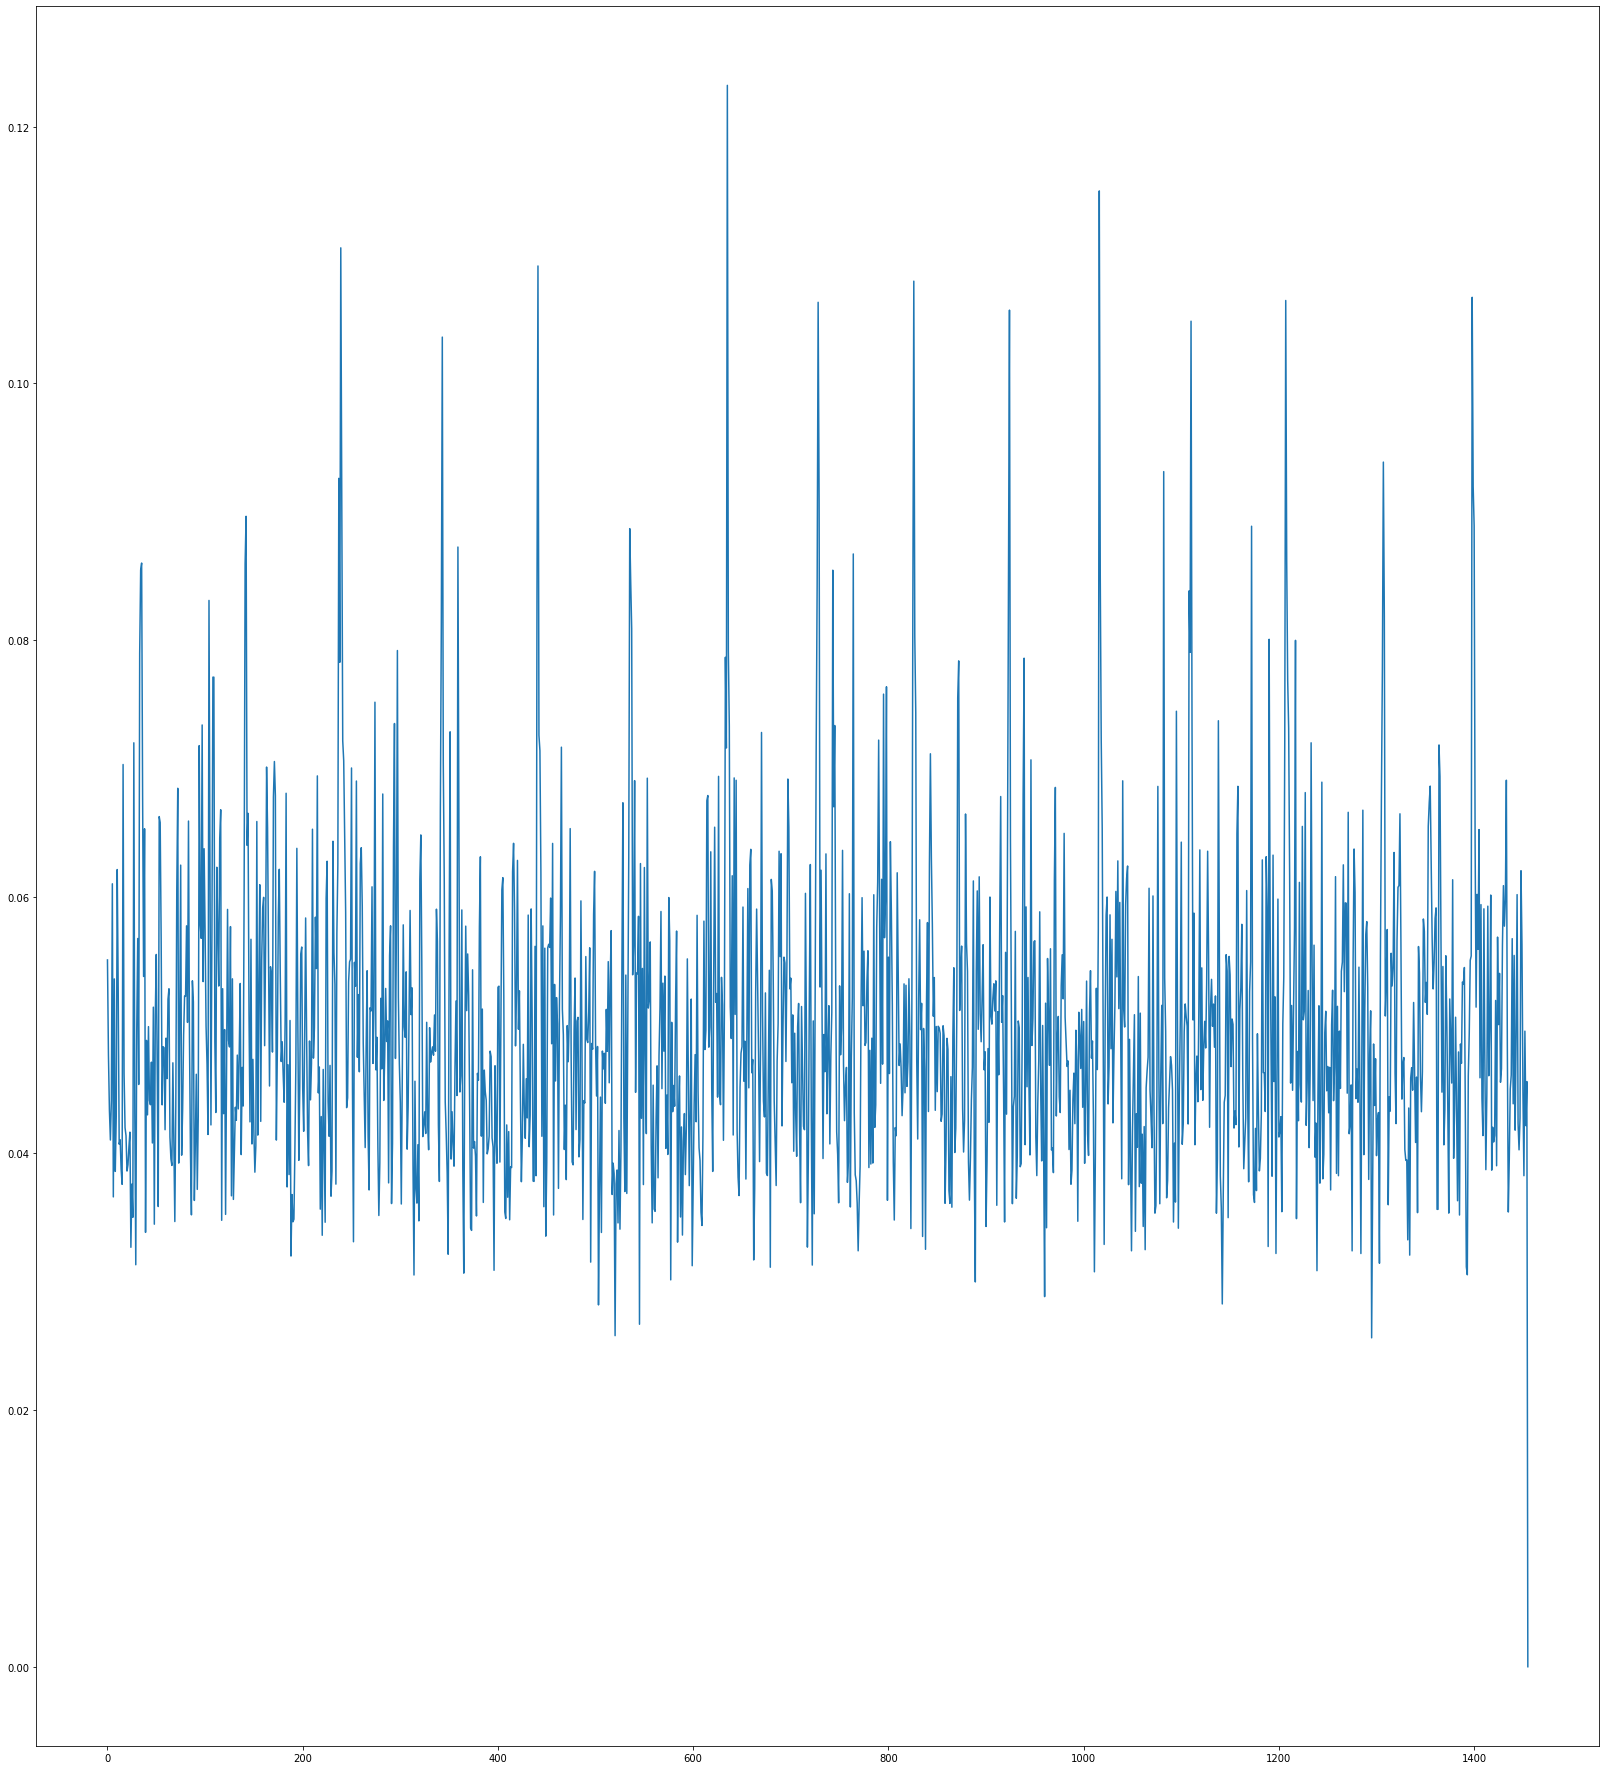

In [48]:
plt.plot(ee)

In [49]:
subFolders = sorted(list(listdir_nohidden(RootPath)))
print(subFolders)

['220221_ICells_Mattek_s01', '220221_ICells_Mattek_s02', '220221_ICells_Mattek_s03', '220221_ICells_Mattek_s04', '220221_ICells_Mattek_s05', '220221_ICells_Mattek_s06', '220221_ICells_Mattek_s07', '220221_ICells_Mattek_s08', '220221_ICells_Mattek_s09', '220221_ICells_Mattek_s10', '220221_ICells_Mattek_s11', '220221_ICells_Mattek_s12', '220221_ICells_Mattek_s13', '220221_ICells_Mattek_s14', '220221_ICells_Mattek_s15', '220221_ICells_Mattek_s16', '220221_ICells_Mattek_s17', '220221_ICells_Mattek_s18', '220221_ICells_Mattek_s19', '220221_ICells_Mattek_s20', '220221_ICells_Mattek_s21', '220221_ICells_Mattek_s22', '220221_ICells_Mattek_s23', '220221_ICells_Mattek_s24', '220221_ICells_Mattek_s25']


In [51]:
print(subFolders[:,:,2])

TypeError: list indices must be integers or slices, not tuple